### Twitter Sentiment Analysis Lab

#### Dataset (ai2.csv)
The dataset contains approximately 19883 different (scrapped) tweets with the following attributes:
- 'id'         : unique 19 digit id for each tweet
- 'created_at' : date & time of each tweet (or retweet)
- 'text'       : tweet details/ description 


#### Objective 
- **Sentiment label** - for each tweet based on it's text, devise a method to assign an appropriate sentiment ('positive', 'negative' or 'neutral'). This is achieved by using TextBlob (https://textblob.readthedocs.io/en/dev/)
- **Text Analytics/NLP** - to extract features from tweet texts
- **Machine Learning** - Building a robust & optimized ML model to accurately predict the sentiment associated with each tweet & explanation of the built model

In [3]:
# mount data from Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/ai2.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19883 entries, 0 to 19882
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          19883 non-null  float64
 1   created_at  19883 non-null  object 
 2   date        19883 non-null  object 
 3   time        19883 non-null  object 
 4   tweet       19883 non-null  object 
dtypes: float64(1), object(4)
memory usage: 776.8+ KB


In [ ]:
# Libraries for data preparation & visualisation

import re
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud


# Library to ignore warnings

import warnings
warnings.filterwarnings("ignore")

# Library for assigning sentiment label

from textblob import TextBlob

# Libraries for text analytics

import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter  import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries for ML modeling 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import GridSearchCV, cross_val_score #cross-validation
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline #not used today
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

In [ ]:
# Reading in data 

data = pd.read_csv('tweets.csv')
data.head()

In [ ]:
# Shape of data

df.shape

(19883, 5)

- There are 19883 rows & 5 columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19883 entries, 0 to 19882
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          19883 non-null  float64
 1   created_at  19883 non-null  object 
 2   date        19883 non-null  object 
 3   time        19883 non-null  object 
 4   tweet       19883 non-null  object 
dtypes: float64(1), object(4)
memory usage: 776.8+ KB


- 'id' is a 16 digit random number associated with each tweet. This should have no relevance on final modeling & can be dropped 
- 'created_at' is of object type & will be converted to datetime format
- 'location' has 442 missing records 

In [ ]:
# Dropping 'id'

df = df.drop('id', axis=1)

In [ ]:
# Changing datatype for created_at 

df['created_at'] = pd.to_datetime(df['created_at'])

In [ ]:
# Replacing missing records under location with 'unknown'

data = data.fillna('Unknown')

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,first,last
created_at,19883,18043,2022-08-31 17:06:13+00:00,9,2022-08-30 07:04:48+00:00,2022-09-01 10:09:46+00:00
date,19883,3,31/08/2022,9283,NaT,NaT
time,19883,16551,18:30:00,10,NaT,NaT
tweet,19883,19513,What can you learn from #AI advances in medica...,16,NaT,NaT


- 'text' value is repeated in the dataset, e.g., text 'RT @NHLBlackhawks: Staying warm never looked s...' occurs 25 times in the dataset. This indicates some of the texts have retweets 

In [ ]:
# Checking duplicates 

df.duplicated().sum()

5

- There are 5 duplicate records 

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

Now we have removed duplicates.

In [ ]:
# Checking for missing values 

df.isnull().sum().sum()

0

- No further missing values 

#### Feature Engineering & EDA

In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=cabacafb0a6d71b1bc7672f6ab289e63c359b453aa507c1f66e40bc7c08624c7
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [ ]:
# Language detection

from langdetect import detect

def language_detection(text):
    
    try:
        language = detect(text)
        return(language)
    except:
        return('error')

df['language'] = df['tweet'].apply(language_detection)

In [ ]:
df.head()

,created_at,date,time,tweet,language
0,2022-09-01 10:09:46+00:00,01/09/2022,10:09:46,#workathome #digitalnomad #WFH DevOps Enginee...,en
1,2022-09-01 10:09:42+00:00,01/09/2022,10:09:42,Neurobiology: Wellspring of Machine Learning w...,en
2,2022-09-01 10:08:58+00:00,01/09/2022,10:08:58,Opening for remote Lead Flask Developer with P...,en
3,2022-09-01 10:08:22+00:00,01/09/2022,10:08:22,Bytesview's advanced #textanalysis tools let y...,en
5,2022-09-01 10:07:51+00:00,01/09/2022,10:07:51,Opening for remote Seeking Django Developer wi...,en


In [ ]:
# Language 

df['language'].value_counts()

en    17421
it       17
fr       12
nl        7
ca        5
et        5
af        4
ja        3
no        3
da        2
de        2
id        2
cy        2
tr        1
sw        1
hr        1
th        1
es        1
tl        1
ro        1
Name: language, dtype: int64

In [ ]:
# Filter the dataset to only contain english texts

df = df[df['language']=='en']
df.drop('language', axis=1, inplace=True)

In [ ]:
# Shape of data

df.shape

(17421, 4)

- There are 17421 rows remaining 

In [ ]:
# Create new features from 'created_at'

# Day of the week
df['day_of_week'] = df['created_at'].dt.dayofweek
df['day_of_week'] = df['day_of_week'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',\
                                                   4:'Friday', 5:'Saturday',6:'Sunday'})

In [ ]:
# Hour 

df['hour']        = df['created_at'].dt.hour + df['created_at'].dt.minute/60

In [ ]:
# Value counts for day_of_week

df['day_of_week'].value_counts()

Wednesday    8228
Tuesday      6375
Thursday     2818
Name: day_of_week, dtype: int64

only 3 days showm, of which Wednesday had the highest number of tweets

In [ ]:
# Dropping the 'created_at' attribute

df = df.drop('created_at', axis=1)

In [ ]:
# Let's create target column, i.e., sentiment associated with text

# Defining a function to assign sentiments (positive, negative or neutral)

def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'
    
df['sentiment'] = df['tweet'].apply(get_sentiment)

In [ ]:
# Value counts for sentiment

df['sentiment'].value_counts()

positive    8086
neutral     6675
negative    2660
Name: sentiment, dtype: int64

- Maximum tweets have a positive sentiment followed by neutral sentiment

In [ ]:
from pandas.core.groupby.generic import DataFrameGroupBy
# function to create labeled barplots


def labeled_barplot(df, feature, target ,perc=False, n=None):

    total = len(df[feature])  # length of the column
    count = DataFrameGroupBy[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 5))
    else:
        plt.figure(figsize=(n + 2, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(df=df.sort_values(by=target),x=feature,palette="Paired",hue=target,\
                       order=df[feature].value_counts().index[:n].sort_values(),)

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(100 * p.get_height() / total)  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(label,(x, y),ha="center",va="center",size=12,xytext=(0, 5),textcoords="offset points",)  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
data = df.copy()
data.head()

,date,time,tweet,day_of_week,hour,sentiment
0,01/09/2022,10:09:46,#workathome #digitalnomad #WFH DevOps Enginee...,Thursday,10.150000,negative
1,01/09/2022,10:09:42,Neurobiology: Wellspring of Machine Learning w...,Thursday,10.150000,positive
2,01/09/2022,10:08:58,Opening for remote Lead Flask Developer with P...,Thursday,10.133333,negative
3,01/09/2022,10:08:22,Bytesview's advanced #textanalysis tools let y...,Thursday,10.133333,positive
5,01/09/2022,10:07:51,Opening for remote Seeking Django Developer wi...,Thursday,10.116667,negative


In [ ]:
# day_of_week
from pandas.api.types import CategoricalDtype
cats     = ['Tuesday', 'Wednesday', 'Thursday']
cat_type = CategoricalDtype(categories=cats, ordered=True)

data['day_of_week']=data['day_of_week'].astype(cat_type)

labeled_barplot(data, 'day_of_week', 'sentiment')

NameError: ignored

- All weekdays (except Tuesdays) have majority of tweets as positive tweets, while weekends & Tuesdays have majority of tweets as neutral tweets 

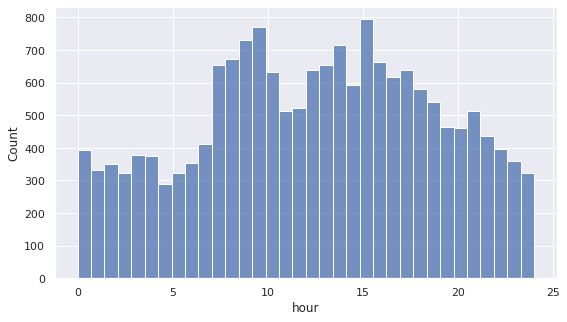

In [ ]:
# hour

plt.figure(figsize=(9,5))
sns.histplot(data=data, x='hour');

- Majority of the tweets are in the mid-morning late afternoons (peaking after 3PM)

New features will be created by counting number of positive & negative words in each tweet. The list of all positive & negative words are borrowed from this study: https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
positive_words =pd.read_csv('/content/drive/MyDrive/positive-words.txt',skiprows=35, names=['words']) 
positive_words = positive_words['words'].values.tolist()

In [ ]:
import pandas as pd
negative_words =pd.read_csv('/content/drive/MyDrive/negative-words.txt',skiprows=35, names=['words']) 
negative_words = negative_words['words'].values.tolist()

In [ ]:
# Let's create new features, i.e., number of positive & negative words associated with each text

# Defining a function to count number of positive & negative words

def count_words(tweet, words): 
    count = 0
    for word in tweet.split(' '):
        if word in words:
            count += 1
    return count

data['number_positive_words'] = data['tweet'].apply(count_words, words=positive_words)
data['number_negative_words'] = data['tweet'].apply(count_words, words=negative_words)

In [ ]:
# Function to create stacked barplots

def stacked_barplot(data, predictor, target):

    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(by=sorter, ascending=False)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(by=predictor, ascending=True)
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(loc="lower left", frameon=False,)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

sentiment              negative  neutral  positive    All
number_positive_words                                    
All                        2660     6675      8086  17421
0                          2049     6024      4549  12622
1                           436      530      2279   3245
2                           136       96       908   1140
3                            25       19       250    294
4                            12        5        64     81
5                             1        1        24     26
6                             1        0        10     11
7                             0        0         2      2
------------------------------------------------------------------------------------------------------------------------


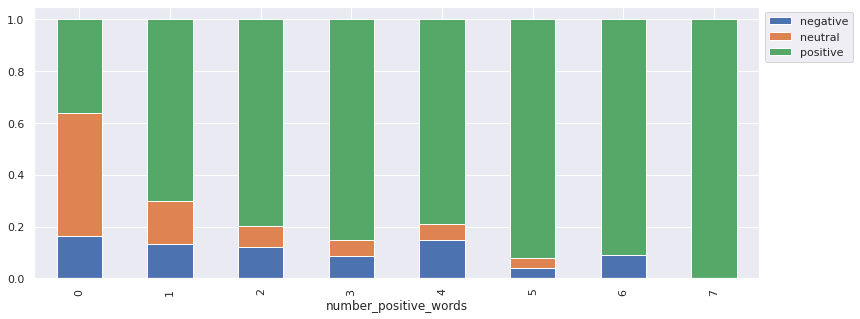

In [ ]:
# number_positive_words

stacked_barplot(data, 'number_positive_words', 'sentiment')

- Tweets with 0 or 1 count for number_positive_words have all three sentiments 'neutral', 'positive' & 'negative' 
- Tweets with 1, 2, 3 or 4 number_positive_words are majorly a 'positive' sentiment as expected

sentiment              negative  neutral  positive    All
number_negative_words                                    
All                        2660     6675      8086  17421
0                          2135     6268      6990  15393
1                           362      358       904   1624
2                           133       40       160    333
3                            24        6        25     55
4                             3        2         5     10
5                             2        1         1      4
6                             1        0         1      2
------------------------------------------------------------------------------------------------------------------------


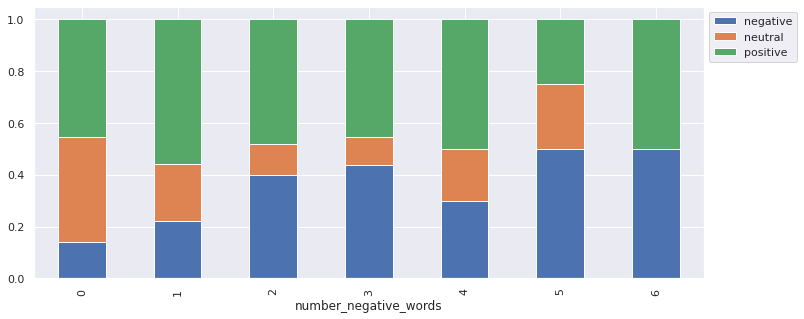

In [ ]:
# number_negative_words

stacked_barplot(data, 'number_negative_words', 'sentiment')

- Tweets with 0 or 1 count for number_negative_words have all three sentiments 'neutral', 'positive' & 'negative'
- Apart from 4 - the more negatiev words the tweet has the gigher the neative sentiment, as expected. But do you think 4 is different?

In [ ]:
data.head()

,date,time,tweet,day_of_week,hour,sentiment,number_positive_words,number_negative_words
0,01/09/2022,10:09:46,#workathome #digitalnomad #WFH DevOps Enginee...,Thursday,10.150000,negative,0,0
1,01/09/2022,10:09:42,Neurobiology: Wellspring of Machine Learning w...,Thursday,10.150000,positive,1,0
2,01/09/2022,10:08:58,Opening for remote Lead Flask Developer with P...,Thursday,10.133333,negative,0,0
3,01/09/2022,10:08:22,Bytesview's advanced #textanalysis tools let y...,Thursday,10.133333,positive,2,0
5,01/09/2022,10:07:51,Opening for remote Seeking Django Developer wi...,Thursday,10.116667,negative,0,0


We see tweets have upper and lower case.

In [ ]:
# Convert tweets to lowercase 

data['tweet'] = data['tweet'].str.lower()

# Remove non-alphanumeric character from tweets such as '@'

def remove_non_alphanumeric(tweet):
    pattern = re.compile('\W')
    x = re.sub(pattern, ' ', tweet)
    return(x)
    
data['tweet'] = data['tweet'].apply(remove_non_alphanumeric)

data.head()

,date,time,tweet,day_of_week,hour,sentiment,number_positive_words,number_negative_words
0,01/09/2022,10:09:46,workathome digitalnomad wfh devops enginee...,Thursday,10.150000,negative,0,0
1,01/09/2022,10:09:42,neurobiology wellspring of machine learning w...,Thursday,10.150000,positive,1,0
2,01/09/2022,10:08:58,opening for remote lead flask developer with p...,Thursday,10.133333,negative,0,0
3,01/09/2022,10:08:22,bytesview s advanced textanalysis tools let y...,Thursday,10.133333,positive,2,0
5,01/09/2022,10:07:51,opening for remote seeking django developer wi...,Thursday,10.116667,negative,0,0


- The text has been converted to lowercase & non-alphanumerical characters such as @ & # have been removed 

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Tokenize sentences to arrays of words

data['tokens'] = data['tweet'].apply(nltk.word_tokenize)

data.head()

,date,time,tweet,day_of_week,hour,sentiment,number_positive_words,number_negative_words,tokens
0,01/09/2022,10:09:46,workathome digitalnomad wfh devops enginee...,Thursday,10.150000,negative,0,0,"[workathome, digitalnomad, wfh, devops, engine..."
1,01/09/2022,10:09:42,neurobiology wellspring of machine learning w...,Thursday,10.150000,positive,1,0,"[neurobiology, wellspring, of, machine, learni..."
2,01/09/2022,10:08:58,opening for remote lead flask developer with p...,Thursday,10.133333,negative,0,0,"[opening, for, remote, lead, flask, developer,..."
3,01/09/2022,10:08:22,bytesview s advanced textanalysis tools let y...,Thursday,10.133333,positive,2,0,"[bytesview, s, advanced, textanalysis, tools, ..."
5,01/09/2022,10:07:51,opening for remote seeking django developer wi...,Thursday,10.116667,negative,0,0,"[opening, for, remote, seeking, django, develo..."


In [ ]:
# Lemmatize the words
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
lem = WordNetLemmatizer()
data['tokens'] = data['tokens'].apply(lambda x: [lem.lemmatize(word) for word in x])

data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,date,time,tweet,day_of_week,hour,sentiment,number_positive_words,number_negative_words,tokens
0,01/09/2022,10:09:46,workathome digitalnomad wfh devops enginee...,Thursday,10.150000,negative,0,0,"[workathome, digitalnomad, wfh, devops, engine..."
1,01/09/2022,10:09:42,neurobiology wellspring of machine learning w...,Thursday,10.150000,positive,1,0,"[neurobiology, wellspring, of, machine, learni..."
2,01/09/2022,10:08:58,opening for remote lead flask developer with p...,Thursday,10.133333,negative,0,0,"[opening, for, remote, lead, flask, developer,..."
3,01/09/2022,10:08:22,bytesview s advanced textanalysis tools let y...,Thursday,10.133333,positive,2,0,"[bytesview, s, advanced, textanalysis, tool, l..."
5,01/09/2022,10:07:51,opening for remote seeking django developer wi...,Thursday,10.116667,negative,0,0,"[opening, for, remote, seeking, django, develo..."


- We can see examples of words being broken down to the root  

In [ ]:
# Stemming the words

stem = PorterStemmer()
data['tokens'] = data['tokens'].apply(lambda x: [stem.stem(word) for word in x])

data['tokens'] = data['tokens'].str.join(' ')

data.head()

,date,time,tweet,day_of_week,hour,sentiment,number_positive_words,number_negative_words,tokens
0,01/09/2022,10:09:46,workathome digitalnomad wfh devops enginee...,Thursday,10.150000,negative,0,0,workathom digitalnomad wfh devop engin remot t...
1,01/09/2022,10:09:42,neurobiology wellspring of machine learning w...,Thursday,10.150000,positive,1,0,neurobiolog wellspr of machin learn with prof ...
2,01/09/2022,10:08:58,opening for remote lead flask developer with p...,Thursday,10.133333,negative,0,0,open for remot lead flask develop with python ...
3,01/09/2022,10:08:22,bytesview s advanced textanalysis tools let y...,Thursday,10.133333,positive,2,0,bytesview s advanc textanalysi tool let you co...
5,01/09/2022,10:07:51,opening for remote seeking django developer wi...,Thursday,10.116667,negative,0,0,open for remot seek django develop with javasc...


- We can see examples of words being broken down to root (irrespective of the tense) like opening has become open; seeking becamse seek - a few odd ones too.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
old_data=pd.read_csv('/content/drive/MyDrive/ai2.csv')

Mounted at /content/drive


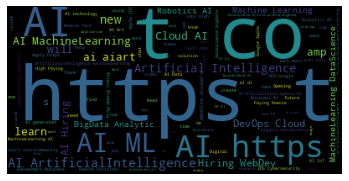

In [ ]:
# Let's plot a word cloud to see the difference between original tweets & tweets post data cleaning

# Original tweets


old_data['tweet'].to_csv('tweetsonly.csv')  
text2 = open('tweetsonly.csv').read()

wordcloud = WordCloud().generate(text2)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

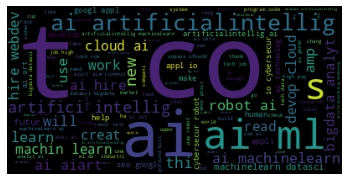

In [ ]:
# tweets post data cleaning

data['tokens'].to_csv('cleanedtweetsonly.csv')  
text3 = open('cleanedtweetsonly.csv').read()

wordcloud = WordCloud().generate(text3)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


- 'HTTPS' was a common occurrence in the original tweets but is no longer a common occurrence in cleaned up tweets. Anything else?

In [ ]:
# Dropping tweet column 

data = data.drop('tweet', axis=1)

### Machine Learning

In [ ]:
data['sentiment'] = data['sentiment'].replace({'neutral':0, 'positive':1, 'negative':-1})
data['sentiment'] = data['sentiment'].astype(int)

In [ ]:
# Assign features & target as X & y respectively

X = data.drop('sentiment', axis=1)
y = data['sentiment']

In [ ]:
# One hot encoding of day_of_week column

X = pd.get_dummies(X, columns=['day_of_week'], drop_first=True)

In [ ]:
# Split data into train & test set using stratify to maintain the split of sentiment across train & test sets

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y,\
                                                   shuffle=True)

In [ ]:
# Shape of splits 

X_train_full.shape

(13936, 8)

In [ ]:
X_test.shape

(3485, 8)

- There are now 8 columns & 13936 and 3485 rows respectively in full training & test sets

In [ ]:
y_train_full.value_counts(normalize=True)

 1    0.464122
 0    0.383180
-1    0.152698
Name: sentiment, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

 1    0.464275
 0    0.383070
-1    0.152654
Name: sentiment, dtype: float64

- Stratify has maintained the split of neutral ('0'), positive ('1') & negative ('-1') tweets in the dataset

We would like each class to be predicted correctly. Tuning the 'F1' metric will ensure the maximum possibility of correct predictions across each of the target classes

Further, the following additional points need consideration

- Vectorizer 'TFIDF' is chosen to convert text data to numerical feature matrix 
- RandomOverSampler would be needed to handle class imbalance across target classes
- Further, choice of ML model(s) that work well with textual data- Multinomial Naive Baiyes, Linear Support Vector Classifier, Random Forest Classifier & XGBoost 
